In [1]:
import sys
sys.path.append('../sgmm')
sys.path.append('../metrics')
sys.path.append('../Misc')
sys.path.append('../visual')
sys.path.append('../otherModels')
sys.path.append('../LogOdds')

In [2]:
import numpy as np
import pandas as pd
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults
from mlModels import logisticRegressionCv2, neural_nets, randomforests,\
kmeansLogRegr, xboost, gradboost,kmeansBNB
from sklearn.naive_bayes import BernoulliNB
from supervisedBmm import SupervisedBMM
from utility import entropy,asymm_entropy,purity
from ftest_logodds import ftest_uncorr
from ftest_logodds import restest
#from clustmap import plotclustmap
from clustmap_newborn import plotclustmap
from sklearn.linear_model import LogisticRegression

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sparcs = pd.read_csv("~/data/CDPHP/xiao/SPARCS_Subsets/Obsolete/sparcs25%Newborn_DeHos_Outflow_Region.csv") 

d_newborn_tr, d_newborn_te = train_test_split(sparcs, test_size=0.2, random_state = 1512)

print(d_newborn_tr.shape[0], d_newborn_tr.shape[1])

93543 260


In [5]:
# metric matrix columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

In [6]:
# feature list
features = list(sparcs.iloc[:,:-1])

In [7]:
#Preparing the data
Xtrain, Xtest = d_newborn_tr.iloc[:,0:-1].values, d_newborn_te.iloc[:,0:-1].values
ytrain, ytest = d_newborn_tr.iloc[:,-1].values.astype(int), d_newborn_te.iloc[:,-1].values.astype(int)

# Nonclustering Classification

In [8]:
# Fitting a Bernoulli Naive Bayes
bnb = BernoulliNB(alpha= 1,class_prior=[0.75,0.25])
bnb.fit(Xtrain, ytrain)
probTrainNB,probTestNB = bnb.predict_proba(Xtrain)[:,1], bnb.predict_proba(Xtest)[:,1]
tau = optimalTau(probTrainNB, ytrain)
metTest,_ = calc_metrics(custom_prob = probTestNB.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNB.copy(), tau = tau, y = ytrain)
metTestNB = pd.DataFrame( [metTest], columns = columns)
metTrainNB = pd.DataFrame( [metTrain], columns = columns)

In [9]:
#FITTING L1 LOGISTIC REGRESSION
Cs = [1,10,100,1000]
pL1, probTestL1, probTrainL1 = logisticRegressionCv2( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest, Cs = Cs )
tau = optimalTau(probTrainL1, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestL1.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainL1.copy(), tau = tau, y = ytrain)
metTestL1 = pd.DataFrame( [metTest], columns = columns)
metTrainL1 = pd.DataFrame( [metTrain], columns = columns)

In [10]:
#Fitting Neural Nets
pNN, probTestNN, probTrainNN = neural_nets( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest,
                                                  h_l_s = (4 ,4, 2))
tau = optimalTau(probTrainNN, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestNN.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNN.copy(), tau = tau, y = ytrain)
metTestNN = pd.DataFrame( [metTest], columns = columns)
metTrainNN = pd.DataFrame( [metTrain], columns = columns)

In [11]:
#RANDOM FORESTS
params, probTest, probTrain = randomforests(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestRF = pd.DataFrame( [metTest], columns = columns)
metTrainRF = pd.DataFrame( [metTrain], columns = columns)


In [12]:
#Ada boost
params, probTest, probTrain = xboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestXB = pd.DataFrame( [metTest], columns = columns)
metTrainXB = pd.DataFrame( [metTrain], columns = columns)

In [13]:
#Grad boost
params, probTest, probTrain = gradboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestGB = pd.DataFrame( [metTest], columns = columns)
metTrainGB = pd.DataFrame( [metTrain], columns = columns)

# Sequential clustering + classification

In [14]:
np.random.seed( seed = 0 )
#Kmeans + LG
n_clusters = 7

Cs = [1,10,100,1000]
kmeansParams = kmeansLogRegr(Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, Cs = Cs, n_clusters = n_clusters)

modelsKM = kmeansParams['models']
labTrKM, labTestKM  = kmeansParams['labelsTrain'], kmeansParams['labelsTest']


# KMS class accuracy
metTrainKMc, metTestKMc = metrics_cluster(models = modelsKM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKM,
                                        trainlabels = labTrKM,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [15]:
# KMS LG overall accuaracy
probTr= np.array([])
for i in range(len(kmeansParams['probTrain'])):
    probTr = np.append(probTr,kmeansParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKM==i])

probTe= np.array([])
for i in range(len(kmeansParams['probTest'])):
    probTe = np.append(probTe,kmeansParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKM==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMS = pd.DataFrame( [metTrain], columns = columns)
metTestKMS = pd.DataFrame( [metTest], columns = columns)

In [16]:
np.random.seed( seed = 0)
# kmeans + NB classifier
n_clusters = 7

kmeansNBParams = kmeansBNB( Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, n_clusters = n_clusters)
modelsKMNB = kmeansNBParams['models']
labTrKMNB, labTestKMNB  = kmeansNBParams['labelsTrain'], kmeansNBParams['labelsTest']


# KMS class accuracy
metTrainKMcNB, metTestKMcNB = metrics_cluster(models = modelsKMNB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKMNB,
                                        trainlabels = labTrKMNB,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [17]:
# KMS + NB overall accuaracy
probTr= np.array([])
for i in range(len(kmeansNBParams['probTrain'])):
    probTr = np.append(probTr,kmeansNBParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKMNB==i])

probTe= np.array([])
for i in range(len(kmeansNBParams['probTest'])):
    probTe = np.append(probTe,kmeansNBParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKMNB==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMSNB = pd.DataFrame( [metTrain], columns = columns)
metTestKMSNB = pd.DataFrame( [metTest], columns = columns)

In [18]:
# GMM + Classification (LG) (simple = 1)
np.random.seed( seed = 0)

max_iter = 30
max_iter2 = 30
n_clusters = 7

model = SupervisedGMM( max_iter = max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain, simple = 1, kmeans = 1)
# Retrieve memberships and labels
mTrainGMMLG = model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain  = fitP['labTrain']
mTestGMMLG = model.predict_GMMS(Xtest)
labTest = np.argmax( mTestGMMLG, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestGMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainGMMLG = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainGMMLGc, metTestGMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)



GMM iteration: 0, error: 0.09327058475275019
GMM iteration: 1, error: 0.025050285088014143
GMM iteration: 2, error: 0.008536295770835128
GMM iteration: 3, error: 0.032698169368191365
GMM iteration: 4, error: 0.007657922628052533
GMM iteration: 5, error: 0.002306569425461942
GMM iteration: 6, error: 0.009646278150177408
GMM iteration: 7, error: 0.0025540599655253407
GMM iteration: 8, error: 0.0006426859021145045


In [19]:
# BMM + Classification (LG)
np.random.seed( seed = 0 )

max_iter = 30
max_iter2 = 30
n_clusters = 7

modelB = SupervisedBMM( n_clusters = n_clusters,max_iter = max_iter,max_iter2 = max_iter2)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain,simple=1, kmeans= 1)

mTrainBMMLG = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrain  = fitP['labTrain']
mTestBMMLG = modelB.predict_BMMS(Xtest)
labTest = np.argmax( mTestBMMLG, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestBMMLG = pd.DataFrame( [metTest], columns = columns)
metTrainBMMLG = pd.DataFrame( [metTrain], columns = columns)

metTrainBMMLGc, metTestBMMLGc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTest,
                                        trainlabels = labTrain,
                                        Xtrain = Xtrain, Xtest = Xtest)


BMM iteration: 0, error: 0.01771020588128663
BMM iteration: 1, error: 0.015249699051172986
BMM iteration: 2, error: 0.0109532427729811
BMM iteration: 3, error: 0.005717405485657545
BMM iteration: 4, error: 0.0026016607101168425
BMM iteration: 5, error: 0.0011227753830232805
BMM iteration: 6, error: 0.0005920395360191742


In [20]:
np.random.seed( seed = 21274 )
# train SGMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7

model = SupervisedGMM(max_iter=max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
model = model.fit(Xtrain = Xtrain, ytrain = ytrain)

# Retrieve memberships and labels
mTrainSGMM = model.mTrain
logisRegreSGMM = model.LogRegr
fitP = model.fitParams
labTrainSGMM  = fitP['labTrain']
mTestSGMM = model.predict_GMMS(Xtest)
labTestSGMM = np.argmax( mTestSGMM, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSGMM = pd.DataFrame( [metTest], columns = columns)
metTrainSGMM = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainSGc, metTestSGc = metrics_cluster(models = logisRegreSGMM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestSGMM,
                                        trainlabels = labTrainSGMM,
                                        Xtrain = Xtrain, Xtest = Xtest)

GMM iteration: 0, error: 0.23222237355540218
GMM iteration: 1, error: 0.06131224840088673
GMM iteration: 2, error: 0.01303220782211413
GMM iteration: 3, error: 0.0031063806057638694
GMM iteration: 4, error: 0.0008042940500014271


In [21]:
np.random.seed( seed = 71730 )

# train SBMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7

modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2,verbose =0)
modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrainSBMM = modelB.mTrain
logisRegreB = modelB.LogRegr
fitPB = modelB.fitParams
labTrainSBMM  = fitPB['labTrain']
mTestSBMM = modelB.predict_BMMS(Xtest)
labTestSBMM = np.argmax( mTestSBMM, axis = 1 )

probTestB, probTrainB = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tauB = optimalTau(probTrainB, ytrain)
metTestB,_ = calc_metrics(custom_prob = probTestB.copy(), tau = tauB, y = ytest)
metTrainB ,_= calc_metrics(custom_prob = probTrainB.copy(), tau = tauB, y = ytrain)
metTestSBMM = pd.DataFrame( [metTestB], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrainB], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegreB, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestSBMM,
                                        trainlabels = labTrainSBMM,
                                        Xtrain = Xtrain, Xtest = Xtest)

BMM iteration: 0, error: 0.0675707887146993
BMM iteration: 1, error: 0.01409099100589041
BMM iteration: 2, error: 0.0092475629172788
BMM iteration: 3, error: 0.023066072080298892
BMM iteration: 4, error: 0.04737609403956464
BMM iteration: 5, error: 0.07221454209495304
BMM iteration: 6, error: 0.06753383613180379
BMM iteration: 7, error: 0.05137688027748509
BMM iteration: 8, error: 0.03614654767083504
BMM iteration: 9, error: 0.024187990597847264
BMM iteration: 10, error: 0.015169739489185728
BMM iteration: 11, error: 0.00906096143022051
BMM iteration: 12, error: 0.005924451556670542
BMM iteration: 13, error: 0.004988286320807712
BMM iteration: 14, error: 0.005131041999314162
BMM iteration: 15, error: 0.005208313849002869
BMM iteration: 16, error: 0.00504143586409147
BMM iteration: 17, error: 0.004662258483707117
BMM iteration: 18, error: 0.00434827667746954
BMM iteration: 19, error: 0.004176176999680372
BMM iteration: 20, error: 0.004108553871133893
BMM iteration: 21, error: 0.00396202

# Overall predition accuracy

In [22]:
# Comparison acucuracy with other methods
trainmet = pd.concat([metTrainNB, metTrainL1,metTrainNN,metTrainRF,metTrainXB,metTrainGB, metTrainKMS,metTrainKMSNB,metTrainGMMLG,metTrainBMMLG,metTrainSGMM,metTrainSBMM],ignore_index=True)
testmet = pd.concat([metTestNB, metTestL1,metTestNN,metTestRF,metTestXB,metTestGB, metTestKMS,metTestKMSNB,metTestGMMLG,metTestBMMLG,metTestSGMM,metTestSBMM],ignore_index=True)
method = ['Naive Bayes','L1 Log Reg','Neural Network','Random Forest','AdaBoost','GradBoost','KMS + Log Reg','KMS + NB', 'GMM + Log Reg', 'BMM + Log Reg', 'SGMM w/ Log Reg', 'SBMM w/ Log Reg']
trainmet.insert(8,'method',method)
testmet.insert(8,'method',method)

In [23]:
print( 'Overall prediction accuracy')
testmet.iloc[:,8:].round(2)

Overall prediction accuracy


,method,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,Naive Bayes,0.19,0.81,0.58,0.50,0.75,0.70,0.54,0.78
1,L1 Log Reg,0.26,0.74,0.70,0.47,0.73,0.72,0.56,0.81
2,Neural Network,0.17,0.83,0.61,0.54,0.77,0.72,0.57,0.82
3,Random Forest,0.17,0.83,0.61,0.55,0.78,0.72,0.58,0.82
4,AdaBoost,0.24,0.76,0.65,0.48,0.73,0.71,0.55,0.78
5,GradBoost,0.26,0.74,0.68,0.47,0.73,0.71,0.56,0.80
6,KMS + Log Reg,0.21,0.79,0.63,0.50,0.75,0.71,0.56,0.81
7,KMS + NB,0.22,0.78,0.62,0.49,0.74,0.70,0.54,0.79
8,GMM + Log Reg,0.24,0.76,0.68,0.48,0.74,0.72,0.57,0.81
9,BMM + Log Reg,0.18,0.82,0.62,0.53,0.77,0.72,0.57,0.82


# Cadre wise prediction accuracy

In [24]:
print('Kmeans + LG')
print(metTestKMc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
#print('Kmeans + NB')
#print(metTestKMcNB.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('GMM + LG')
print(metTestGMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('BMM + LG')
print(metTestBMMLGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])
print('SGMM w/ LG')
print(metTestSGc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]) #.iloc [[1,0,2,3,4],:]) 
print('SBMM w/ LG')
print(metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]])

Kmeans + LG
     size  high_cost%    f1   auc
0  3579.0        0.15  0.61  0.89
1  1504.0        0.19  0.65  0.86
2  3844.0        0.20  0.61  0.86
3  6408.0        0.27  0.54  0.75
4  2134.0        0.30  0.61  0.81
5  4319.0        0.31  0.53  0.73
6  1598.0        0.33  0.54  0.72
GMM + LG
     size  high_cost%    f1   auc
0  1942.0        0.07  0.68  0.95
1  1123.0        0.23  0.62  0.82
2  9872.0        0.25  0.58  0.82
3  3087.0        0.26  0.54  0.75
4  4407.0        0.27  0.54  0.76
5  2629.0        0.29  0.55  0.75
6   326.0        0.61  0.87  0.91
BMM + LG
     size  high_cost%    f1   auc
0  3382.0        0.16  0.62  0.90
1  2569.0        0.19  0.62  0.87
2  3564.0        0.19  0.67  0.90
3  2683.0        0.26  0.55  0.75
4  2224.0        0.28  0.54  0.77
5  4387.0        0.29  0.55  0.76
6  4577.0        0.33  0.55  0.72
SGMM w/ LG
      size  high_cost%    f1   auc
0    367.0        0.14  0.78  0.97
1    311.0        0.16  0.56  0.77
2    540.0        0.19  0.92  0.99
3  

# Stratification

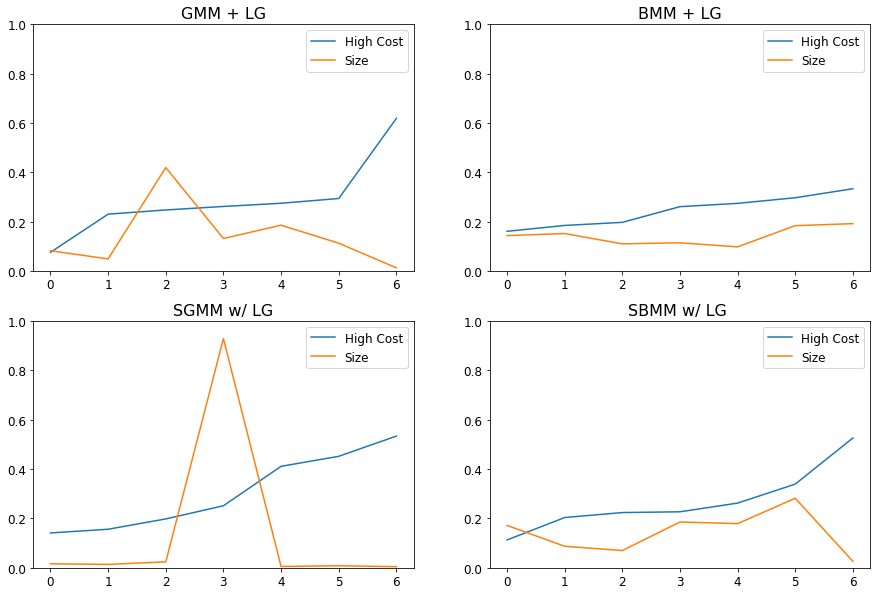

In [25]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y=sorted(metTrainGMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainGMMLGc.shape[0]), y= metTrainGMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('GMM + LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 2)
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y=sorted(metTrainBMMLGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainBMMLGc.shape[0]), y= metTrainBMMLGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('BMM + LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)


plt.subplot(2, 2, 3)
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y=sorted(metTrainSGc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSGc.shape[0]), y= metTrainSGc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SGMM w/ LG',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.subplot(2, 2, 4)
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)

plt.show()

# Class entropy by stratification

In [26]:
# calculate cadre entropy
class_prior = d_newborn_tr['Target'].value_counts(normalize=True)[1]
purityKMSLGlow,purityKMSLGhigh= purity(metTrainKMc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainKMc.sort_values(by ='high_cost%')['size'].values,class_prior)
print('purity of low/high risk by KMS + LG is :{} and :{}' .format(purityKMSLGlow,purityKMSLGhigh ))
purityGMMLGlow,purityGMMLGhigh= purity(metTrainGMMLGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainGMMLGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by GMM+ LG is :{} and :{}'.format( purityGMMLGlow,purityGMMLGhigh ))
purityBMMLGlow,purityBMMLGhigh= purity(metTrainBMMLGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainBMMLGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by BMM+ LG is :{} and :{}'.format (purityBMMLGlow,purityBMMLGhigh ) )
puritySGMMLGlow,puritySGMMLGhigh = purity(metTrainSGc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainSGc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by SGMM w/ LG is :{} and :{} '.format (puritySGMMLGlow,puritySGMMLGhigh ) )
puritySBMMLGlow,puritySBMMLGhigh= purity(metTrainSBc.sort_values(by ='high_cost%')['high_cost%'].values,metTrainSBc.sort_values(by ='high_cost%')['size'].values,class_prior)
print ('purity of low/high risk by SBMM w/ LG is :{} and :{}'.format (puritySBMMLGlow,puritySBMMLGhigh) )

purity of low/high risk by KMS + LG is :0.06076549192325653 and :0.02732882153433014
purity of low/high risk by GMM+ LG is :0.29820575622619094 and :0.365076601892787
purity of low/high risk by BMM+ LG is :0.05473859711022111 and :0.030490497330522226
purity of low/high risk by SGMM w/ LG is :0.08987111012231253 and :0.242855313330114 
purity of low/high risk by SBMM w/ LG is :0.1593780221189316 and :0.23272252328619736


# Cadre Assigment confidence 

In [27]:
# conditional entropy for each method
condEntropyGMMLG = entropy(mTrainGMMLG[:,np.argsort(metTrainGMMLGc['high_cost%'])],n_clusters)
condEntropyBMMLG = entropy(mTrainBMMLG[:,np.argsort(metTrainBMMLGc['high_cost%'])],n_clusters)
condEntropySGMM = entropy(mTrainSGMM[:,np.argsort(metTrainSGc['high_cost%'])],n_clusters)
condEntropySBMM = entropy(mTrainSBMM[:,np.argsort(metTrainSBc['high_cost%'])],n_clusters)
print('GMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyGMMLG)))
print('BMM + LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropyBMMLG)))
print('SGMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySGMM)))
print('SBMM w/ LG average conditional entropy for each cadre is  {}'.format(np.mean(condEntropySBMM)))

GMM + LG average conditional entropy for each cadre is  0.01968854722074202
BMM + LG average conditional entropy for each cadre is  0.09703743334293342
SGMM w/ LG average conditional entropy for each cadre is  0.053679332138812576
SBMM w/ LG average conditional entropy for each cadre is  0.11918924818150574


In [28]:
# conditional entropy for each cluster
print('GMM + LG conditional entropy for each cadre is  {}'.format(condEntropyGMMLG))
print('BMM + LG conditional entropy for each cadre is  {}'.format(condEntropyBMMLG))
print('SGMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySGMM))
print('SBMM w/ LG conditional entropy for each cadre is  {}'.format(condEntropySBMM))

GMM + LG conditional entropy for each cadre is  [0.04162895 0.00531098 0.00159017 0.00218393 0.00160666 0.00252391
 0.08297523]
BMM + LG conditional entropy for each cadre is  [0.11597783 0.13780255 0.10189042 0.00645586 0.29455979 0.01509691
 0.00747867]
SGMM w/ LG conditional entropy for each cadre is  [0.09695788 0.03508417 0.0268324  0.0055807  0.05553274 0.05047298
 0.10529446]
SBMM w/ LG conditional entropy for each cadre is  [0.22375158 0.2735523  0.00665342 0.14082907 0.0841658  0.08452847
 0.0208441 ]


# Interpretability: SGMM

In [29]:
#just change the order of labels so that cost for each cluster goes from low to high

Labels = labTrainSGMM

target = pd.DataFrame(ytrain,columns=['Target'])

cadre = pd.DataFrame(Labels,columns=['Cadre'])

target['Cadre']= cadre['Cadre']

highcostratio = np.array([])
clustpop = np.array([])

for i in range(n_clusters):
    pop = target[target['Cadre']==i]['Target'].shape[0]
    clustpop = np.append(clustpop,pop)
    ratio = np.count_nonzero(target[target['Cadre']==i]['Target'].values)*1.0/pop
    highcostratio= np.append(highcostratio,ratio)
    print(pop,ratio)

504 0.4107142857142857
86792 0.25106000553046365
1288 0.15605590062111802
767 0.4511082138200782
1524 0.1410761154855643
2244 0.19786096256684493
424 0.5330188679245284


In [30]:
print('percent of high cost ratio by SGMM')
print(np.sort(highcostratio).round(2))
print('relative cadre size by SGMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print('Log odds ratio for each cadre by SGMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

percent of high cost ratio by SGMM
[0.14 0.16 0.2  0.25 0.41 0.45 0.53]
relative cadre size by SGMM
[0.016 0.014 0.024 0.928 0.005 0.008 0.005]
Log odds ratio for each cadre by SGMM
[-0.72 -0.59 -0.31  0.04  0.74  0.91  1.24]


In [31]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2   

In [32]:
# Calculate log odds ratios for feature vs. target (whether or not is high cost)
target_binary = d_newborn_tr.iloc[:,-1]
data = d_newborn_tr.iloc[:,:-1]
np_feat = np.asarray(features)
labs_binary = np.expand_dims(target_binary,axis=1)
feat_table_binary,lor_table_binary =ftest_uncorr(data,labs_binary,np_feat)

In [33]:
# just show log odds ratio for race and ethnicity features : 0 lowcost, 1 high cost
pd.DataFrame(lor_table_binary[:,61:69],columns = features[61:69]).round(2)

,Black_African_American,Multi_racial,Other_Race,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity
0,-0.14,-0.59,-0.33,0.54,-0.83,-0.05,-0.06,0.33
1,0.14,0.59,0.33,-0.54,0.83,0.05,0.06,-0.33


In [34]:
# Calculate log odds ratios for feature vs. cadre 
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

In [35]:
# reduce feature length
new_feat = [s.replace('CCS_DX_' , '') for s in features]
new_feat = [s.replace('CCS_PROC_' , '') for s in new_feat]
new_feat = [s.replace('not_mental_disorders_or_infectious_disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually_transmitted_disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]
new_feat = [s.replace('Other','Ot')for s in new_feat]
new_feat = [s.replace('OTHER','OT')for s in new_feat]

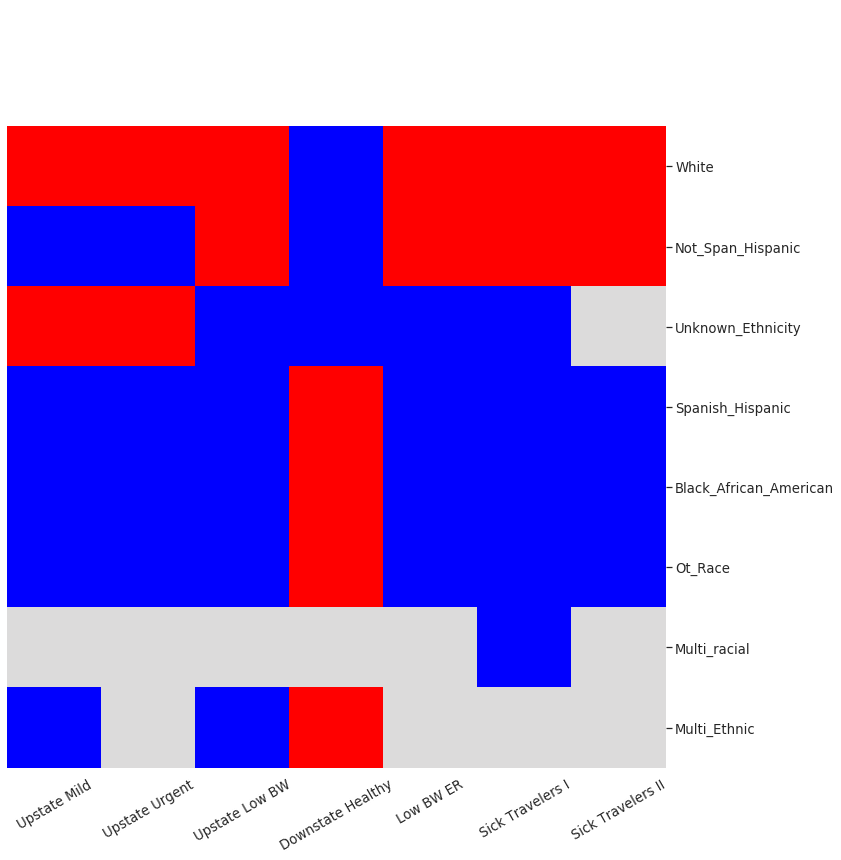

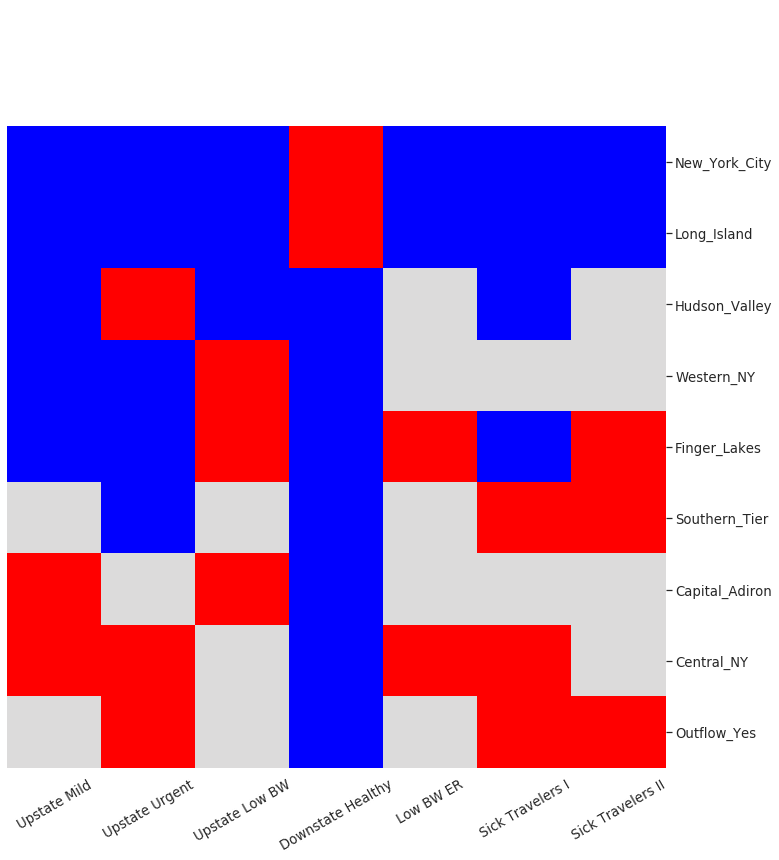

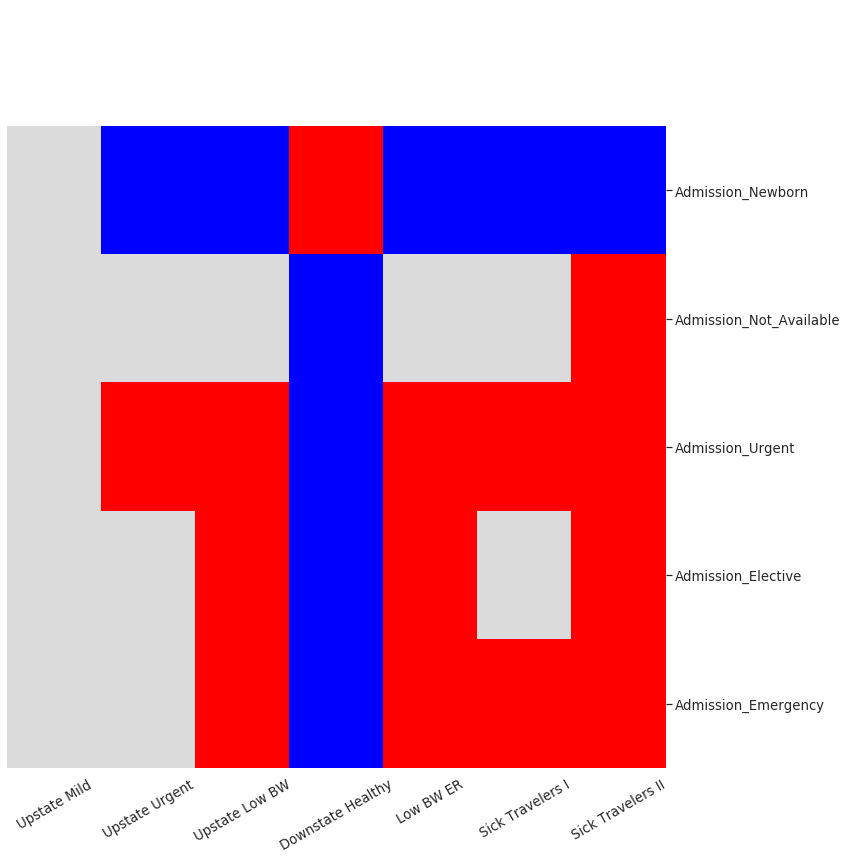

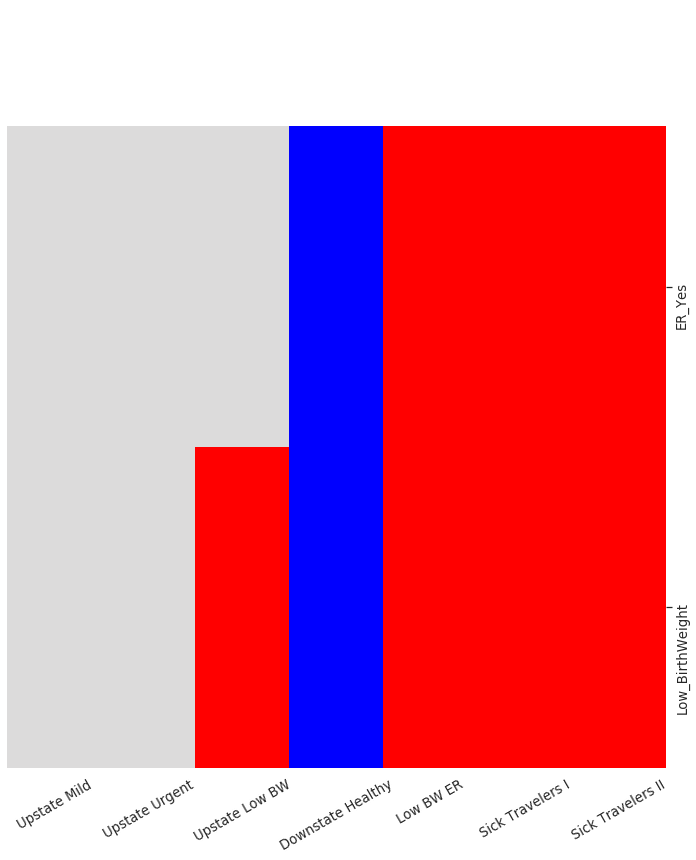

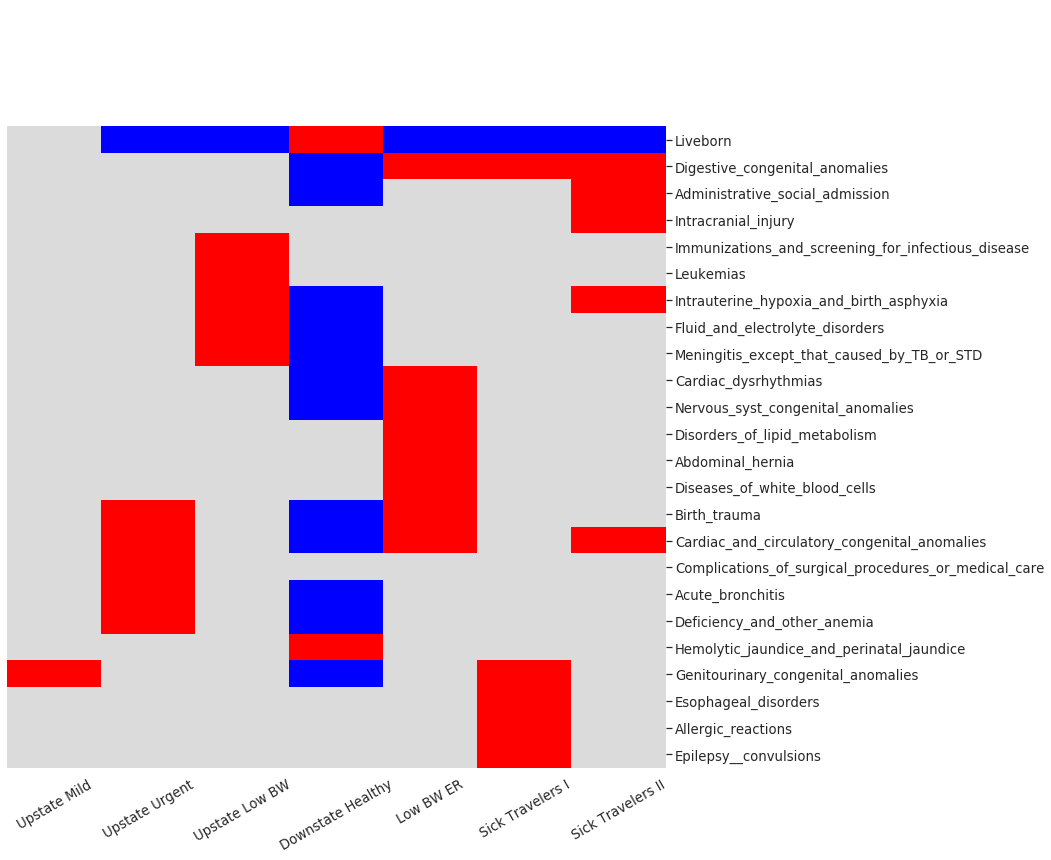

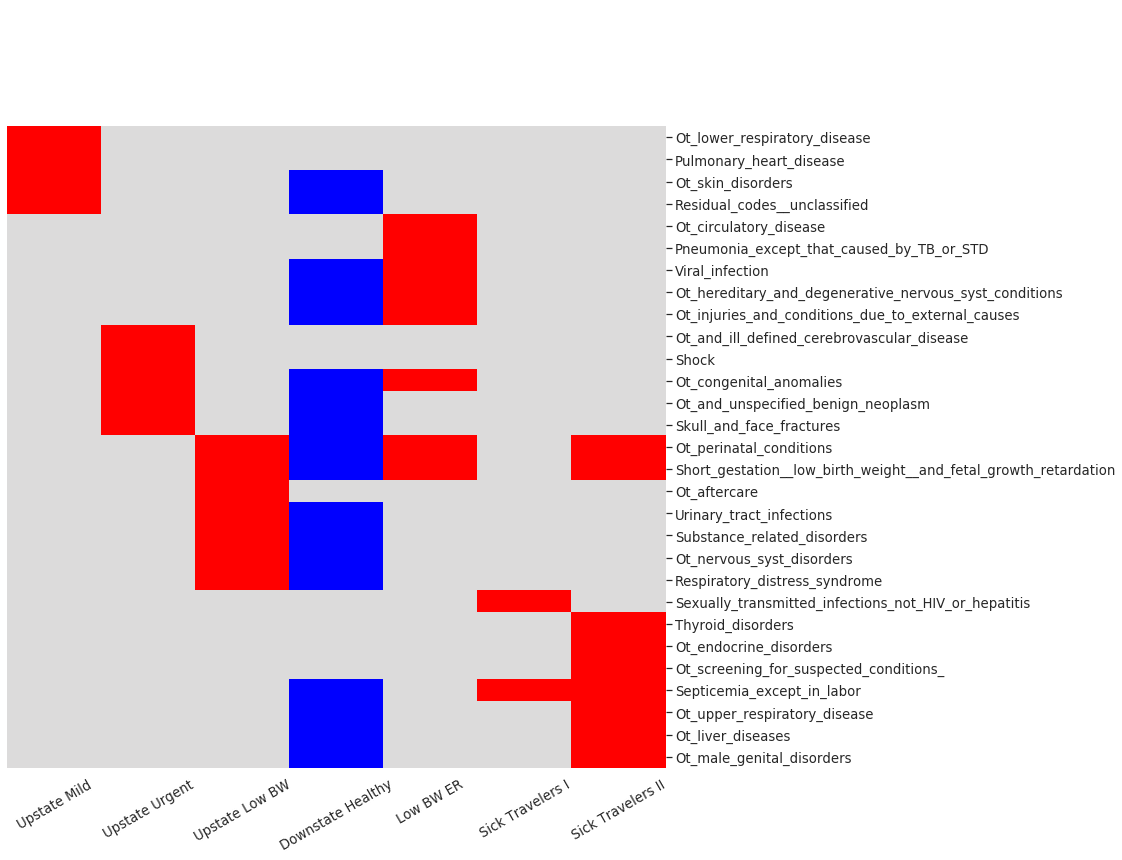

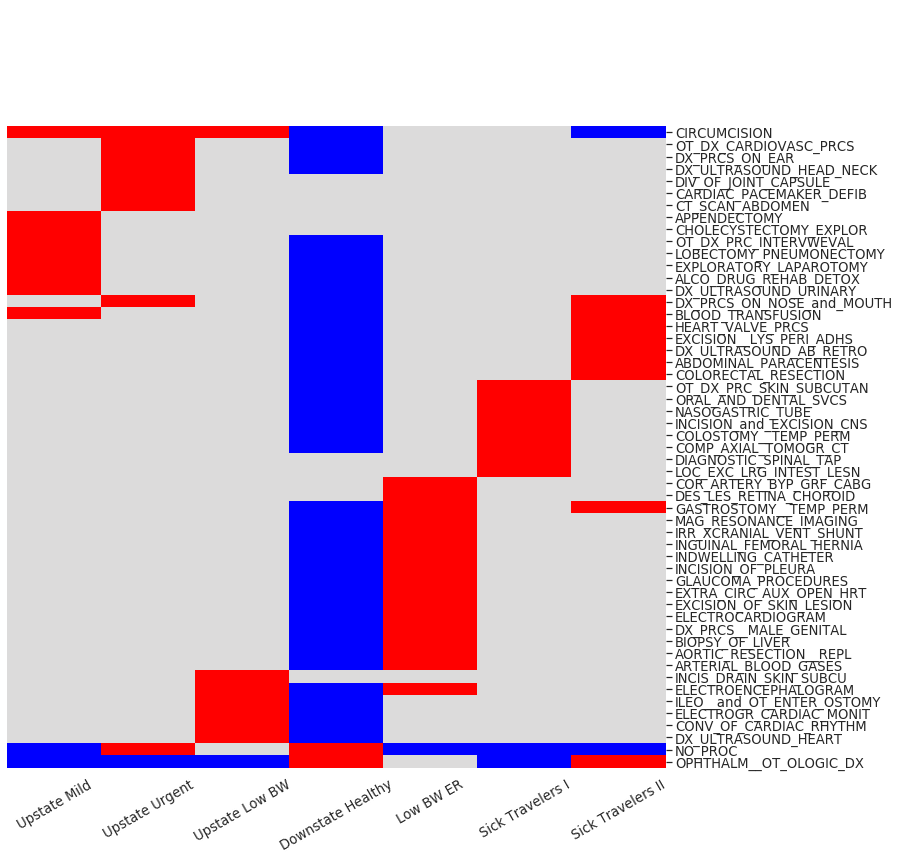

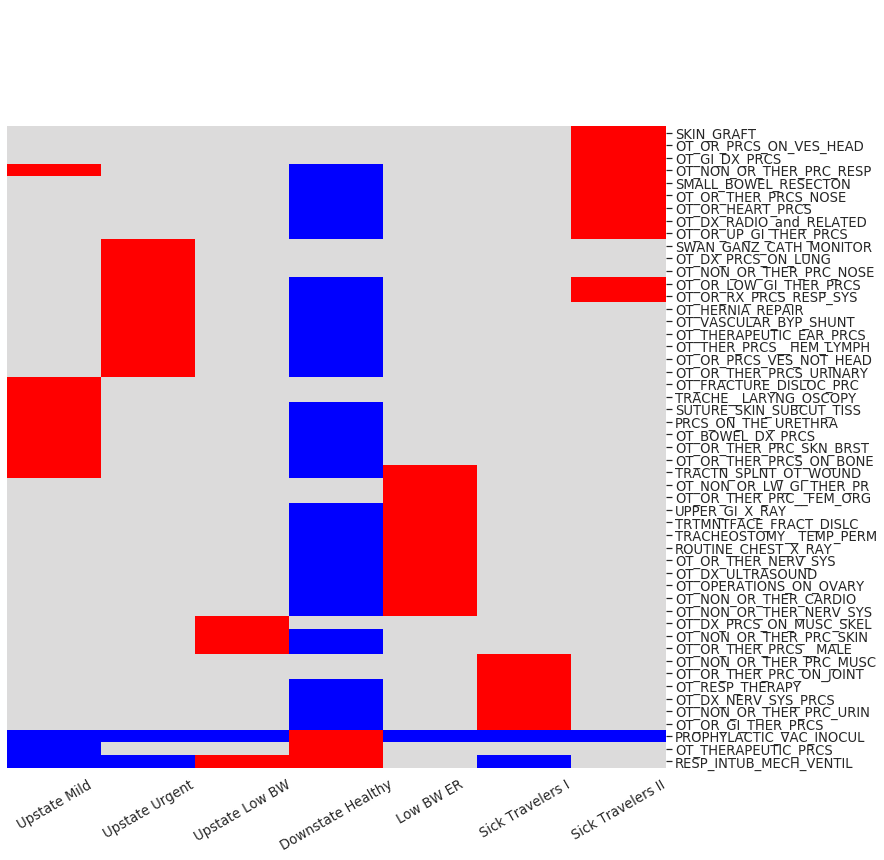

In [36]:
# clustermaps of segments of features.
# Red indicates a given feature has significant positive log ordds ratio to a given cluster, 
# light purple no significance, blue significant negative.

sns.set(font_scale=1.2)
# racial features
plotclustmap(feat_table[:,61:69].T, None, np.array(new_feat)[61:69], None, None)
plt.yticks(rotation=0) 
# county features
plotclustmap(feat_table[:,np.r_[0:8,74]].T,None, np.array(new_feat)[np.r_[0:8,74]],None,None)
plt.yticks(rotation=0)

# # # admission features
plotclustmap(feat_table[:,75:80].T,None,np.array(new_feat)[75:80],None,None)
plt.yticks(rotation=0)

# # ER, Low BW,
plotclustmap(feat_table[:,70:72].T,None,np.array(new_feat)[70:72],None,None)
plt.yticks(rotation=0)

# # #disease features
plotclustmap(feat_table[:,80:110][:,np.sum(abs(feat_table[:,80:110]),axis=0)>0].T,
             None,np.array(new_feat)[80:110][np.sum(abs(feat_table[:,80:110]),axis=0)>0],None,None)
plotclustmap(feat_table[:,110:142][:,np.sum(abs(feat_table[:,110:142]),axis=0)>0].T,
             None,np.array(new_feat)[110:142][np.sum(abs(feat_table[:,110:142]),axis=0)>0],None,None)

# # # procedure features
plotclustmap(feat_table[:,142:200][:,np.sum(abs(feat_table[:,142:200]),axis=0)>0].T,
             None,np.array(new_feat)[142:200][np.sum(abs(feat_table[:,142:200]),axis=0)>0],None,None)

#plotclustmap(feat_table[:,180:220].T,None,np.array(new_feat)[180:220],None,None)
plotclustmap(feat_table[:,200:][:,np.sum(abs(feat_table[:,200:]),axis=0)>0].T,
             None,np.array(new_feat)[200:][np.sum(abs(feat_table[:,200:]),axis=0)>0],None,None)

# cadre weights and predictibility

In [37]:
# extract cadre weights
weights = np.array(model.weights)[:,1:]
sorted_weights = weights[np.argsort( highcostratio ),:].T 

In [38]:
# bootstraping for coefficients of cadres to be significantly nonzero
nBoot=1000

all_coefs = np.zeros((nBoot, n_clusters, len(features)))

for mm in range(n_clusters):
    data_m = d_newborn_tr[labTrainSGMM==mm] 
    
    for b in range(nBoot):
        d_m_b = data_m.sample(frac=1, random_state=b, replace=True)
        log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=logisRegreSGMM[mm].best_params_['C'])
        log_reg.fit(d_m_b[features].values, d_m_b['Target'].values)
        all_coefs[b,mm,:] = np.squeeze(log_reg.coef_)

In [39]:
# estimate a nonzero coefficient with 99% confidence interval
quantiles = np.quantile(all_coefs, (0.005, 0.995), 0)
zero_status = np.zeros((len(features), n_clusters))

for mm in range(n_clusters):
    for p in range(len(features)):
        low_bound, up_bound = quantiles[:,mm,p]
        if low_bound > 0 or up_bound < 0:
            zero_status[p,mm] = 1
zero_status = pd.DataFrame(zero_status, index=features)
zero_status_order = zero_status[np.argsort( highcostratio )]

In [40]:
# make the weights positive, negative, and zero and only consider significant weights from bootstrapping
qualitative_weights = (sorted_weights < 0)*(-1) + (sorted_weights > 0)*1
filtered_weights = qualitative_weights*zero_status_order.values

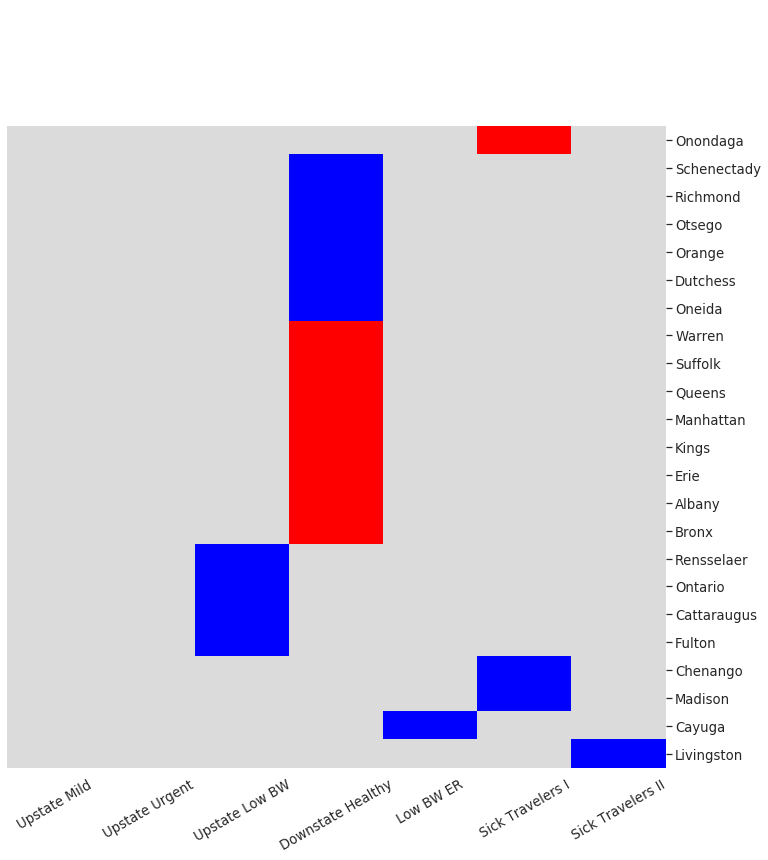

In [41]:
# county weights 
county_weights = filtered_weights[8:58,:]
# plot the clustermap of filtered  county weights 
plotclustmap((county_weights ) [np.sum(abs(county_weights),axis=1)>0,:],
             None, np.array(new_feat[8:58])[np.sum(abs(county_weights),axis=1)>0], None, None)

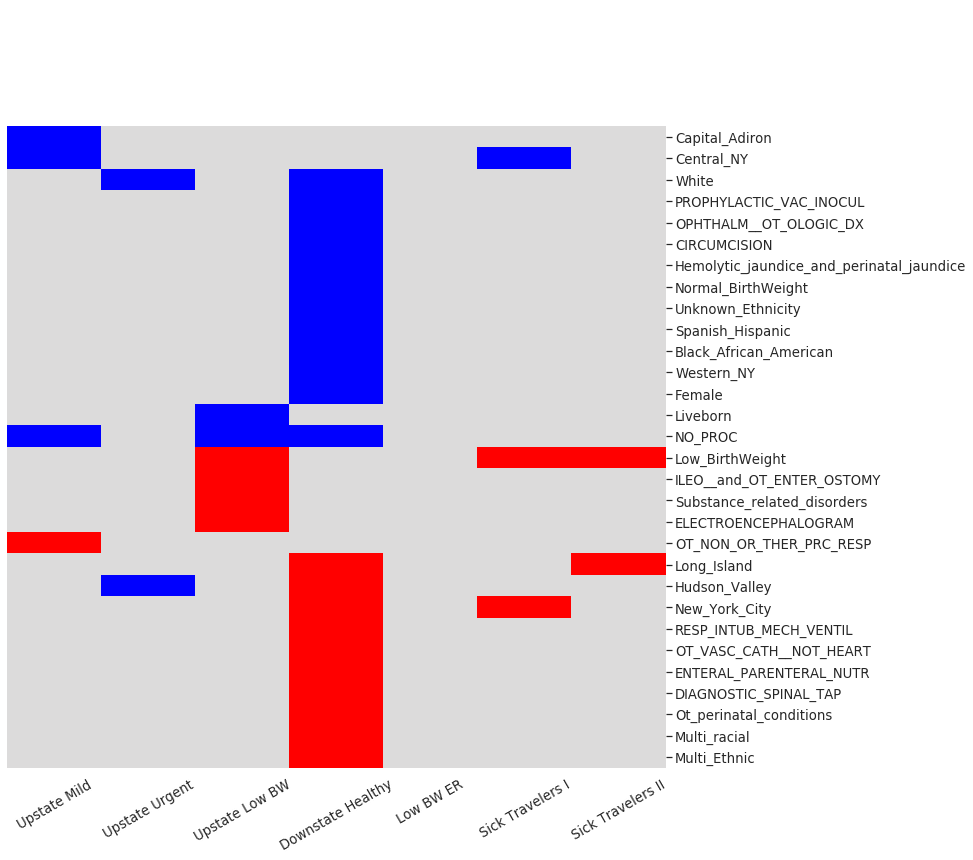

In [42]:
# noncounty weights 
noncounty_weights = filtered_weights[np.r_[0:8,58:259],:]
# plot the clustermap of filtered  noncounty weights 
plotclustmap((noncounty_weights ) [np.sum(abs(noncounty_weights),axis=1)>0,:], 
             None, np.array(new_feat)[np.r_[0:8,58:259]][np.sum(abs(noncounty_weights),axis=1)>0], None, None)